In [2]:
# IPython ~~~ Magic ~~~
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

sys.path.append("..")
from time import sleep
from copy import deepcopy
from utils.viz_tools import visuals
from utils.tools import *
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("fivethirtyeight")
plt.ion()

### Loading the Data

This assumes that you have already downloaded replays either from the data folder or from the [Toribash Forum](https://forum.toribash.com/forumdisplay.php?f=10.). Once that has been done, please create the csv files by running 


```bash
python load_all_replays.py
```

In [4]:
df1 = load_csv("../data/player1_state_info.csv")
df2 = load_csv("../data/player2_state_info.csv")
viz1 = visuals("../data/player1_state_info.csv")
viz2 = visuals("../data/player2_state_info.csv")

In [5]:
print("Number of columns: {}".format(len(df1.columns)))

Number of columns: 152


In [6]:
print("Number of samples: {}".format(len(df1)))

Number of samples: 45563


In [7]:
df1.head(10)

,Unnamed: 0,act_abs,act_chest,act_left_ankle,act_left_elbow,act_left_glute,act_left_grip,act_left_hip,act_left_knee,act_left_pec,...,vel_r_pecs_z,vel_r_thigh_x,vel_r_thigh_y,vel_r_thigh_z,vel_r_triceps_x,vel_r_triceps_y,vel_r_triceps_z,vel_stomach_x,vel_stomach_y,vel_stomach_z
0,0,4.0,2.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-2.747678,0.149009,1.483291,0.464540,-0.090411,-5.872731,1.827661,2.242518,0.478288,-0.360562
2,2,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-1.654234,0.616344,-0.812459,-0.106547,-0.177099,2.141012,2.116282,1.361143,0.444795,-0.684074
3,3,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-1.204972,-0.297085,-2.113958,-0.461157,0.851374,5.831568,1.926617,0.728409,0.155578,-0.972646
4,4,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-2.534410,0.861150,-1.299013,-0.568029,2.486701,6.349423,1.538617,1.116045,0.947698,-1.466941
5,5,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-3.053685,1.951994,-1.083955,-0.575661,4.218004,6.492794,1.455509,2.002954,1.321905,-1.606804
6,6,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-2.149952,0.245840,-1.088391,-0.310076,6.637093,3.827949,1.650394,1.365165,1.363262,-1.374718
7,7,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-1.508992,-0.334280,-1.113255,-0.225947,4.822193,7.085477,2.469094,1.132343,1.174330,-1.221060
8,8,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-0.919339,-0.482116,-1.153553,-0.168317,4.278596,8.463652,2.910065,1.130754,0.866728,-1.086162
9,9,1.0,1.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0,...,-0.381159,-0.452079,-1.197333,-0.101877,3.761086,9.652038,3.080490,1.191316,0.512195,-0.944840


There are so many columns that's hard to see what's going on, but fortunately visuals gives us access to objects that will help us break down this information. The next few cells show some of the positions, velocities, and actions of the first few rows of the dataframe.

In [8]:
# just the x positions
df1[[p for p in viz1.positions if '_x' in p]].head(10)

,pos_breast_x,pos_chest_x,pos_groin_x,pos_head_x,pos_l_biceps_x,pos_l_butt_x,pos_l_foot_x,pos_l_hand_x,pos_l_leg_x,pos_l_pecs_x,...,pos_l_triceps_x,pos_r_biceps_x,pos_r_butt_x,pos_r_foot_x,pos_r_hand_x,pos_r_leg_x,pos_r_pecs_x,pos_r_thigh_x,pos_r_triceps_x,pos_stomach_x
0,1.000000,1.000000,1.000000,1.000000,1.550000,1.200000,1.200000,2.350000,1.200000,1.250000,...,1.950000,0.450000,0.800000,0.800000,-0.350000,0.800000,0.750000,0.800000,0.050000,1.000000
1,1.005169,1.012762,1.003012,0.987747,1.550114,1.199902,1.194113,2.351022,1.203138,1.257012,...,1.950023,0.448432,0.799935,0.793849,-0.361352,0.802976,0.754518,0.800894,0.049458,1.013455
2,1.003854,1.017957,1.013305,0.981313,1.551217,1.209318,1.199571,2.358160,1.207424,1.259737,...,1.950637,0.447067,0.810391,0.776097,-0.359709,0.793445,0.756557,0.804592,0.048395,1.021622
3,1.004218,1.022417,1.018487,0.981892,1.553725,1.216457,1.221083,2.360058,1.216949,1.263928,...,1.949253,0.448411,0.815273,0.752591,-0.345484,0.774743,0.759383,0.802810,0.053503,1.025992
4,1.006691,1.027202,1.029892,0.980508,1.554467,1.228804,1.223729,2.344454,1.221997,1.269889,...,1.941048,0.454036,0.827377,0.750057,-0.314263,0.770719,0.765117,0.807977,0.068423,1.032689
5,1.011175,1.036172,1.046855,0.977351,1.551933,1.245773,1.225476,2.306475,1.227549,1.279524,...,1.919929,0.465400,0.845875,0.749080,-0.267455,0.772169,0.774576,0.819688,0.093731,1.044706
6,1.020072,1.047377,1.048424,0.982915,1.548611,1.247404,1.226171,2.249952,1.229470,1.291928,...,1.889498,0.487715,0.846193,0.750187,-0.233399,0.773280,0.789319,0.821164,0.133554,1.052897
7,1.033543,1.059974,1.046354,0.995460,1.544618,1.244366,1.226459,2.177548,1.229453,1.307482,...,1.851175,0.518421,0.842846,0.751017,-0.217175,0.772636,0.809474,0.819158,0.162487,1.059691
8,1.049971,1.073797,1.043393,1.012696,1.539079,1.239769,1.226535,2.091308,1.228876,1.324686,...,1.805501,0.551738,0.838739,0.751644,-0.211987,0.771244,0.831917,0.816265,0.188159,1.066476
9,1.068225,1.088478,1.040519,1.032706,1.530924,1.234837,1.226533,1.993005,1.228373,1.342092,...,1.752763,0.581950,0.834943,0.752213,-0.202945,0.769764,0.853743,0.813553,0.210725,1.073624


In [9]:
# just the y velocities
df1[[p for p in viz1.velocities if '_y' in p]].head(10)

,vel_breast_y,vel_chest_y,vel_groin_y,vel_head_y,vel_l_biceps_y,vel_l_butt_y,vel_l_foot_y,vel_l_hand_y,vel_l_leg_y,vel_l_pecs_y,...,vel_l_triceps_y,vel_r_biceps_y,vel_r_butt_y,vel_r_foot_y,vel_r_hand_y,vel_r_leg_y,vel_r_pecs_y,vel_r_thigh_y,vel_r_triceps_y,vel_stomach_y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.523894,0.900436,0.538976,0.885630,0.623842,-2.763684,0.362043,-0.252327,0.145840,0.920666,...,-0.191954,-1.555919,4.369801,0.335209,-2.748975,-0.437507,1.058761,1.483291,-5.872731,0.478288
2,2.048743,1.103278,-0.718188,-0.625128,0.327886,-0.841076,-0.061346,-1.573895,-0.461299,1.959604,...,-3.097826,3.191695,-2.233365,0.199567,-2.886689,0.361027,0.877142,-0.812459,2.141012,0.444795
3,2.583964,1.290593,-1.702334,-1.372301,-1.316303,0.315969,-0.356255,-2.330849,-0.867309,1.374421,...,-6.384623,7.310080,-6.012145,-1.058603,-2.806448,0.725768,2.847198,-2.113958,5.831568,0.155578
4,0.719562,0.969875,0.426625,-0.483246,-2.027152,1.128592,0.093807,-7.283920,-0.956132,0.125845,...,-4.317149,7.245121,-1.174869,-0.299015,-1.997797,-0.519438,2.706751,-1.299013,6.349423,0.947698
5,1.184339,1.295505,0.842170,0.607850,-2.834733,1.258301,-0.059486,-11.143831,-1.115208,0.190578,...,-6.551577,6.969509,-0.552914,-0.243285,-0.816265,-0.704313,2.690819,-1.083955,6.492794,1.321905
6,1.027960,1.293899,0.832827,0.724194,-3.466332,1.126024,-0.271683,-12.095250,-1.433162,-0.168186,...,-7.337190,4.867291,-0.465799,-0.263081,5.998101,-0.793354,1.889696,-1.088391,3.827949,1.363262
7,0.526960,0.993467,0.725822,0.182098,-4.192417,1.026929,-0.299972,-12.165646,-1.681893,-0.897117,...,-7.756669,3.104790,-0.450994,-0.284856,12.433063,-0.865645,1.101491,-1.113255,7.085477,1.174330
8,-0.051510,0.576767,0.518097,-0.593178,-4.970119,0.822398,-0.318269,-11.873593,-1.822417,-1.771069,...,-8.030016,2.120695,-0.518679,-0.298058,19.083791,-0.910251,0.565888,-1.153553,8.463652,0.866728
9,-0.615867,0.132714,0.256078,-1.401870,-5.789878,0.557605,-0.334369,-11.332036,-1.827308,-2.746361,...,-8.202311,0.858345,-0.644216,-0.306232,26.073620,-0.929036,0.075487,-1.197333,9.652038,0.512195


Number of matches: 47


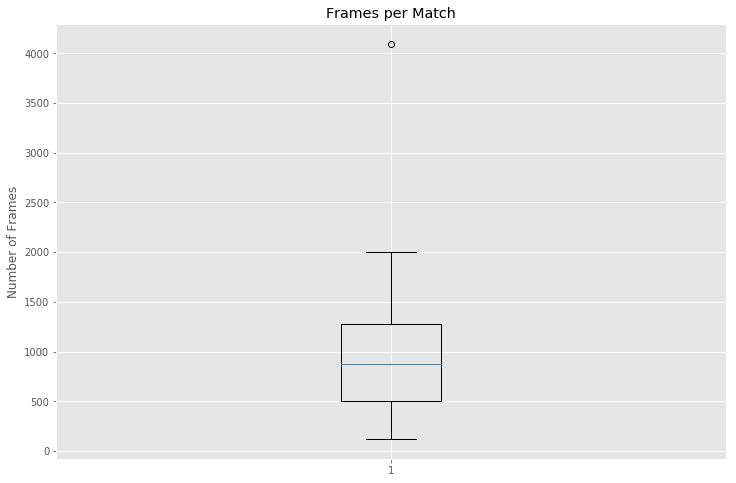

In [10]:
n = len(df1.match.unique())
turns = [max(df1[df1.match == f].turn) for f in df1.match.unique()]
avg = sum(turns)/len(df1.match.unique())
print("Number of matches: {}".format(n))
plt.figure(figsize=(12,8))
plt.title("Frames per Match")
plt.ylabel("Number of Frames")
plt.boxplot(turns)
plt.savefig("Frames_per_match.jpg");

In [11]:
print("Number of inputs used for learning algorithms: {}".format(2*(len(viz1.positions) + len(viz1.velocities) + 22 + 1)))

Number of inputs used for learning algorithms: 298


In [61]:
viz1.match = 14
viz2.match = 14

In [13]:
# watch a replay
sleep(5)
viz1.watch_replay()

Playing Match: ('replay1014192.rpl', 14)


### Custom Visualizations

Let's look at some of the ways we can visualize the data to reason about individual matches as well as how the data is changing over time. 
We will use some of the tools in visuals as well as exploring some relationships between the data. 

First, visualizing a match is not easy. We can watch a replay, but that really just shows how the actions play out. It would be more informative to see how the actions change over the course of a match, so we'll start by using a heatmap to do exactly that. 

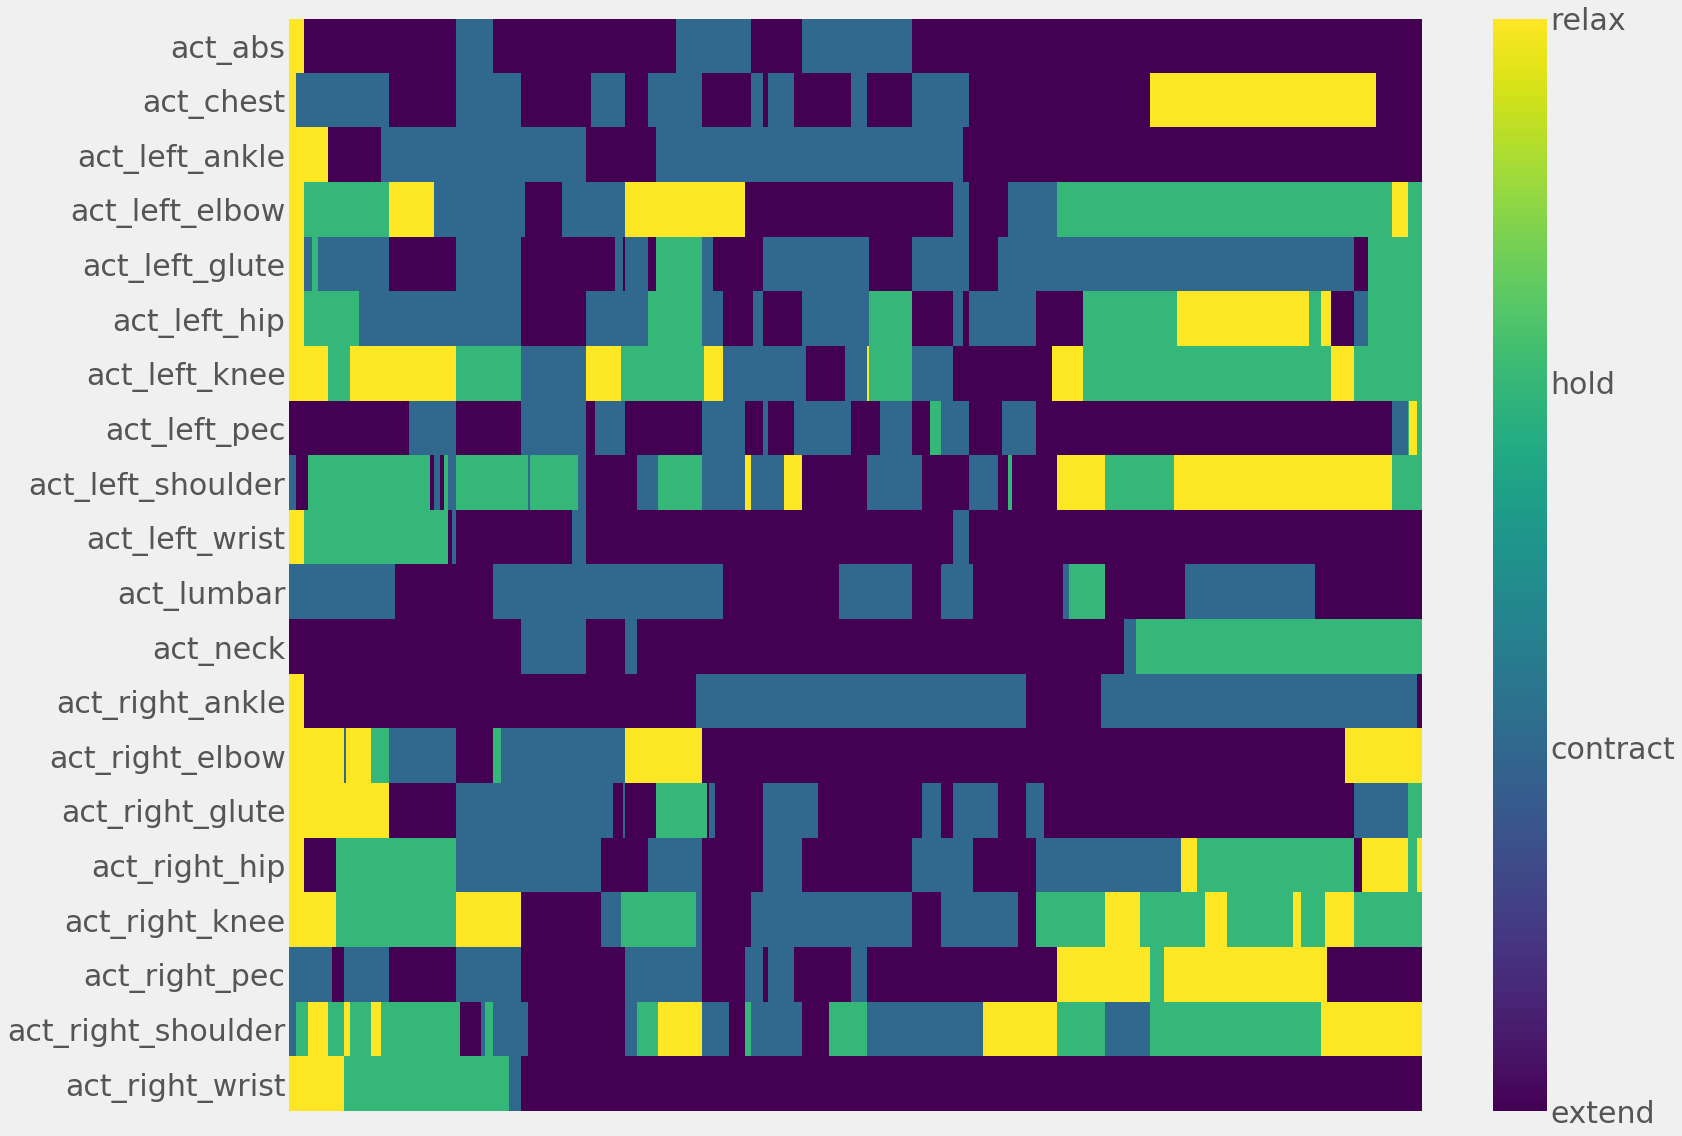

In [62]:
plt.figure(figsize=(24,16))
ax = viz1.heatmap()
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(("extend", 'contract', 'hold', 'relax'))
colorbar.ax.tick_params(labelsize=30)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig('../../images/match_heatmap');

The heatmap above allows us to quickly visualize the actions taken during a match from a player. Also, the colorbar also gives a mapping from color to the type of action taken. Some of the actions, though, may not be exactly what is on the colorbar. For lumbar and chest, the extend color represents right rotate and lean respectively, and contract represents left rotate and lean. For both shoulders, extend means to raise and contract means to lower. 

Furthermore, this representation quickly gives us an idea about how dynamic these matches can be. Below we plot a different match and can quickly see how different it is.

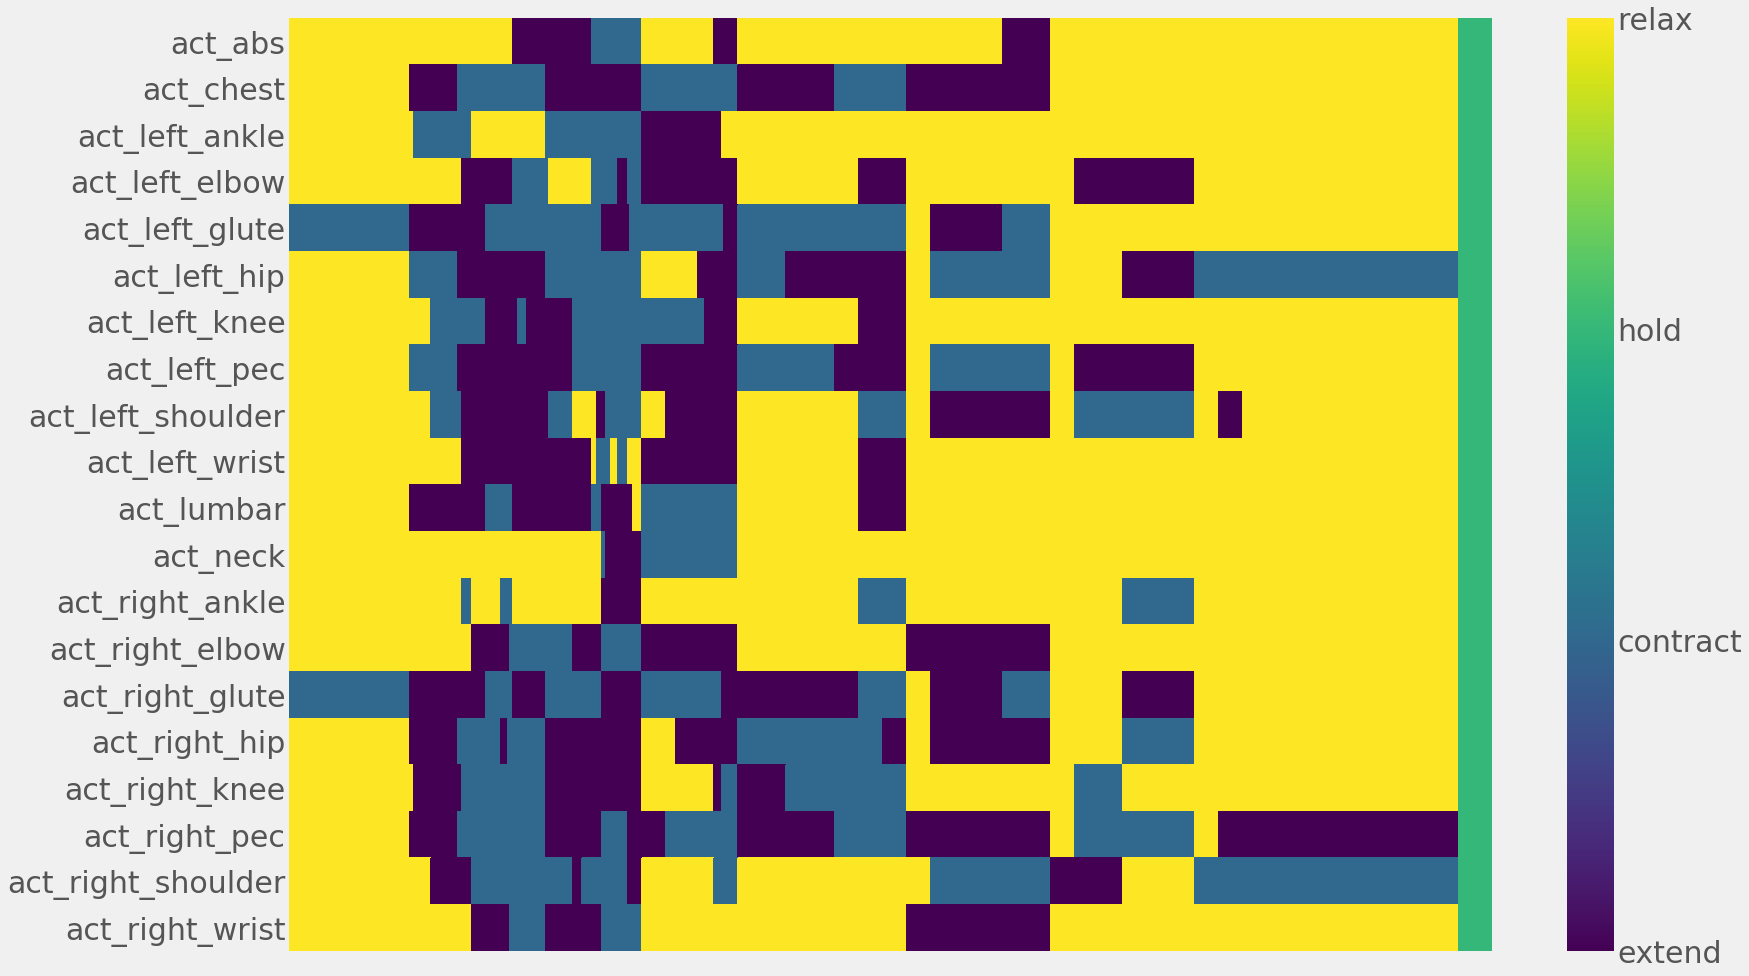

In [59]:
viz1.match = 15
plt.figure(figsize=(24,16))
ax = viz1.heatmap()
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(("extend", 'contract', 'hold', 'relax'))
colorbar.ax.tick_params(labelsize=30)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.yticks(fontsize=30);

In [63]:
viz1.match = 14

#### In-Game Score
Because reinforcement learning relies heavily on the reward function, let's explore the score given by the game and see if it can be useful.

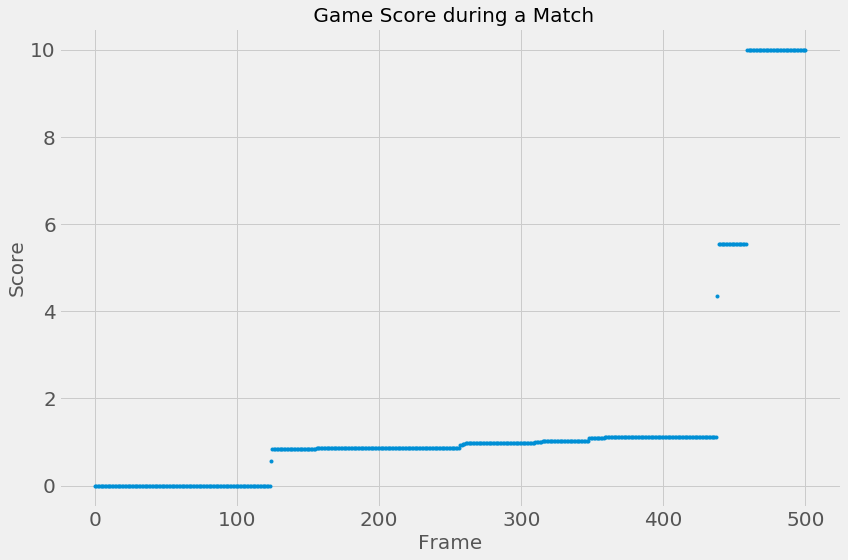

In [19]:
plt.figure(figsize=(12,8))
plt.title(" Game Score during a Match", fontsize=20)
plt.xlabel("Frame", fontsize=20)
plt.ylabel("Score", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
viz1.plot_column("score")
plt.tight_layout()
plt.savefig("../../images/sparse_reward.png");

Unfortunately, the in-game score is too sparse to provide any proper learning. If an agent was following a similar trajectory with the score as the reward function, then it would not recieve any signal until it was more than 20% of the way done with the episode. Below, we'll look at some of the dynamics of the environment and see how we could possibly leverage information from there to derive a more useful function.

Here are some of the other ways we can visualize our actions and information from the matches:
* We can look at the frequency of the actions and how they are being chosen during a match
* We can look at the trajectories of the velocities and positions of the limbs for each player against the score
* We can look at how much the previous action affects the next

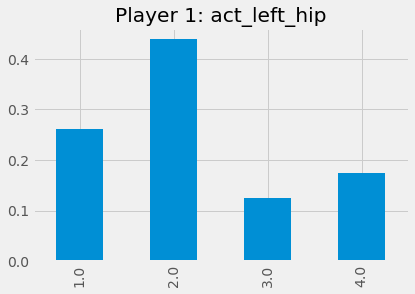

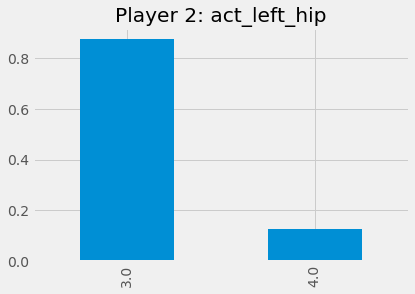

In [20]:
plt.figure()
plt.title("Player 1: {}".format(viz1.actions[5]))
viz1.plot_action_hist(viz1.actions[5])
plt.figure()
plt.title("Player 2: {}".format(viz2.actions[5]))
viz2.plot_action_hist(viz2.actions[5]);

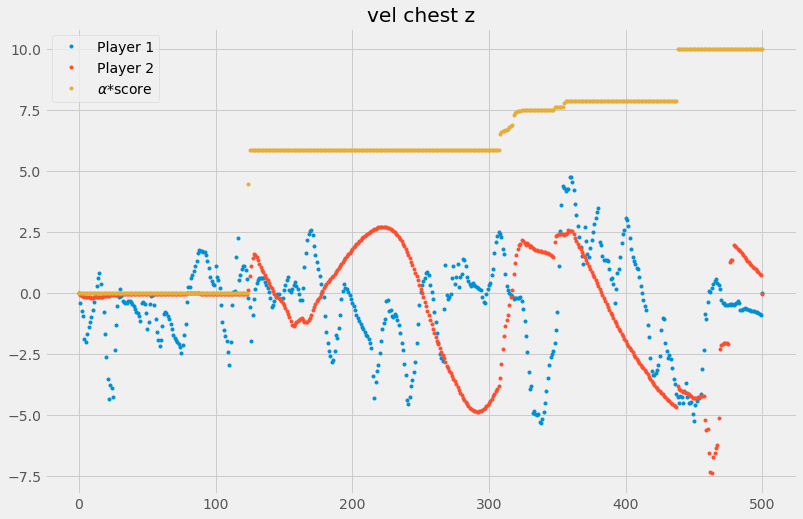

In [21]:
plt.figure(figsize=(12,8))
plt.title(' '.join(viz1.velocities[5].split("_")))
ax1 = viz1.plot_column(viz1.velocities[5])[0]
ax1.set_label("Player 1")
ax2 = viz2.plot_column(viz2.velocities[5])[0]
ax2.set_label("Player 2")
ax3 = viz2.plot_column("score")[0]
ax3.set_label(r"$\alpha$*score")
plt.legend();

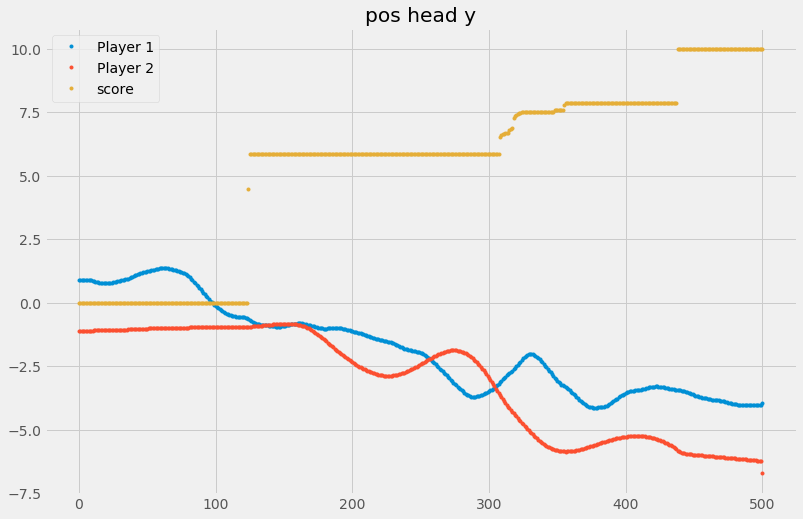

In [22]:
plt.figure(figsize=(12,8))
plt.title(' '.join(viz1.positions[10].split("_")))
ax1 = viz1.plot_column(viz1.positions[10])[0]
ax1.set_label("Player 1")
ax2 = viz2.plot_column(viz2.positions[10])[0]
ax2.set_label("Player 2")
ax3 = viz2.plot_column("score")
plt.legend();

In [23]:
actions_2 = list(map(lambda l: l + '_next', viz1.actions))
df1_shift = deepcopy(df1)
df1_shift[actions_2] = df1[viz1.actions].shift(10)
df1_dropna = df1_shift.dropna()

In [24]:
p_vals = []
r_vals = {}
for act in viz1.actions:
    pair = [act, act+"_next"]
    shift = np.array(df1_dropna[pair])
    slope, intercept, r_value, p_value, std_err = stats.linregress(shift[:, 0], shift[:, 1])
    r_vals[act] = r_value
    p_vals.append(p_value)

In [25]:
p_adj = multipletests(p_vals, method='Bonferroni')

In [26]:
print("Shifted by 10 frames")
print("{:<18}".format("Joint") + "{:>12}".format("r-value"))
print("------------------------------------")
for i,act in enumerate(viz1.actions):
    if(p_vals[i] < 0.005):
        print("{:<18}".format(act) + "{:>12.3f}*".format(r_vals[act]))
    else: 
        print("{:<18}".format(act) + "{:>12.3f}".format(r_vals[act]))

Shifted by 10 frames
Joint                  r-value
------------------------------------
act_abs                  0.838*
act_chest                0.739*
act_left_ankle           0.767*
act_left_elbow           0.763*
act_left_glute           0.723*
act_left_hip             0.670*
act_left_knee            0.647*
act_left_pec             0.764*
act_left_shoulder        0.690*
act_left_wrist           0.879*
act_lumbar               0.761*
act_neck                 0.899*
act_right_ankle          0.784*
act_right_elbow          0.763*
act_right_glute          0.745*
act_right_hip            0.662*
act_right_knee           0.651*
act_right_pec            0.745*
act_right_shoulder       0.652*
act_right_wrist          0.875*


\* represent a p-value of less than 0.005

Of course there is a correlation between temporally linked values! What we need to actually measure is the autocorrelation between these variables. 

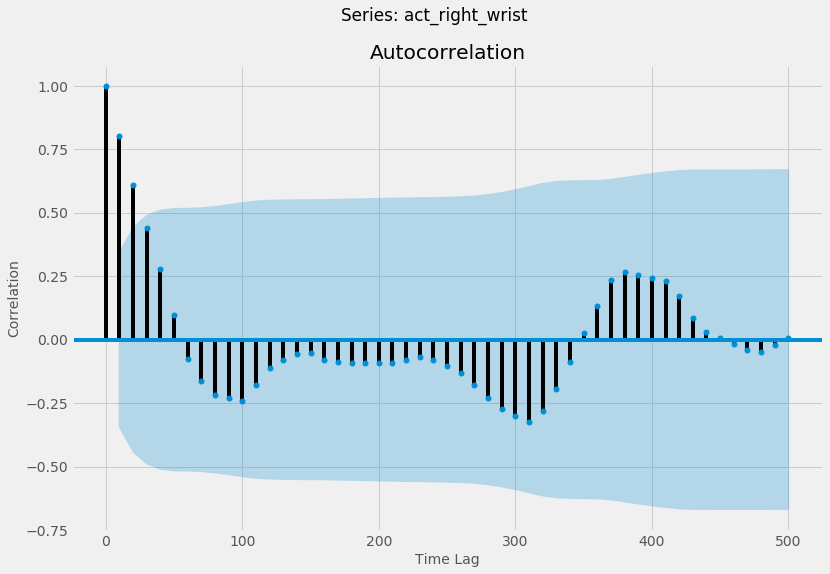

In [40]:
fig,ax = plt.subplots(figsize=(12,8))
plot_acf(viz1.match_df[viz1.actions[0]], lags=np.arange(0, len(viz1.match_df), 10), ax=ax)
plt.suptitle("Series: {}".format(viz1.actions[19]))
plt.xlabel("Time Lag", fontsize=14)
plt.ylabel("Correlation", fontsize=14)
plt.show()

Here, each spike is a measure of correlation between the original series and the series with a lag of $x_i$. In this plot, we measure the autocorrelation between the original series with lags every 10 frames from 0 to the length of the match (500 in this example). This graph tells us that as we get strong correlations in the beginning and, most likely, this relationship propagates throughout the entire match until it eventually tapers off. We can remove this effect by using a partial autocorrelation function to see if there is only a strong relationship at the very beginning (within the first few frames). 

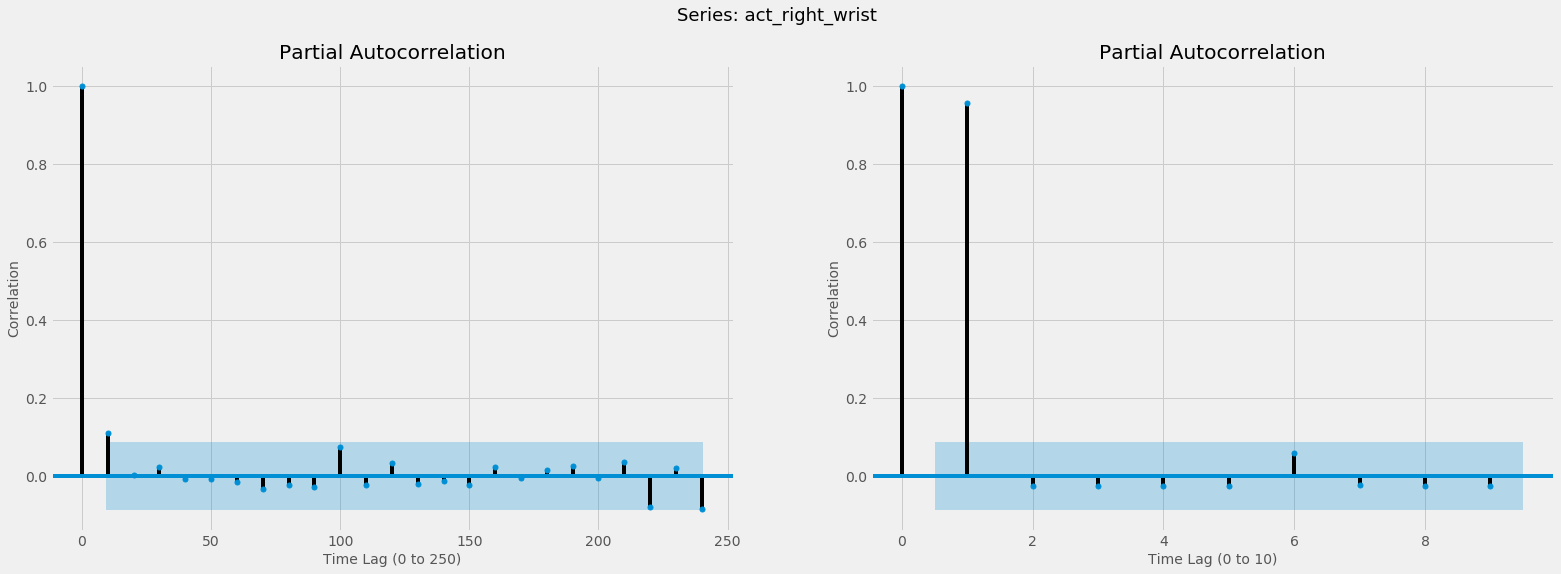

In [55]:
action_idx = 19
fig, axes = plt.subplots(1, 2, figsize=(24,8))
plot_pacf(viz1.match_df[viz1.actions[action_idx]], lags=np.arange(0, len(viz1.match_df)//2, 10), ax=axes[0])
plot_pacf(viz1.match_df[viz1.actions[action_idx]], lags=np.arange(0, 10, 1), ax=axes[1])
fig.suptitle("Series: {}".format(viz1.actions[action_idx]), fontsize=18)
axes[0].set_xlabel("Time Lag (0 to 250)", fontsize=14)
axes[1].set_xlabel("Time Lag (0 to 10)", fontsize=14)
axes[0].set_ylabel("Correlation", fontsize=14)
axes[1].set_ylabel("Correlation", fontsize=14)
plt.show()

We can see clearly that the autocorrelation is limited to the next move giving this an autoregressive property of 1 with $\epsilon$ being some small gaussian noise. Although, this is just one action for just one match, so there may exist unique cases that do not follow this pattern. 